# Phase Estimation Using Ramsey Interferometry


In this notebook, we introduce Ramsey interferometry as a method for phase estimation. One of the primary challenges in quantum computing lies in the sensitivity of qubits to environmental fluctuations. For instance, when a qubit is exposed to a magnetic field, it undergoes a phase change. This characteristic is utilized to achieve highly precise measurements of magnetic fields.

1. [Problem](#1.-Problem)
2. [Ramsey Experiment](#2.-Ramsey-Interferometry)



## Imports

In [ ]:
!pip install qiskit qiskit_aer numpy matplotlib scipy pylatexenc

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from numpy import pi
import math

## 1. Problem

Relative phase shifts in quantum systems does not directly affect final measurement probabilities when measuring in certain bases. This means that looking at the measurement outcomes in, for example, the computational basis ($\ket{0}$ and $\ket{1}$) may not reveal information about these phase shifts.

Generally, qubits are in the form: $\ket{\psi} = \alpha\ket{0} + \beta\ket{1}$

After applying a phase shift of magnitude $\frac{π}{2}$, the state becomes:  $\ket{\psi}  = \alpha\ket{0} + \beta e^{\frac{i\pi}{2}}\ket{1}$

Measuring the qubit at this stage will yield the same probabilities as before the phase shift. Consequently, the phase shift is not reflected in the readout, making it impossible to determine the phase.

$P[\ket{0}] = \alpha^2$

$P[\ket{1}] =  | \beta e^{\frac{i\pi}{2}}|^2 =  \beta e^{\frac{i\pi}{2}} *  \beta e^{\frac{-i\pi}{2}} = \beta^2$

### 1.1 Example

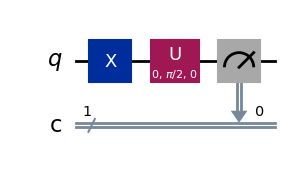

In [2]:
# create a quantum register with 1 qubit and 1 classical bit
numOfQubits = 1
numOfClassBits = 1
circuit = QuantumCircuit(numOfQubits,numOfClassBits)

# initialize qubit to the 1 state
circuit.x(0)

# Phase Shift: perform a 90 degree rotation around the z-axis
phaseAmount = pi/2
circuit.u(0, phaseAmount, 0, 0)

# measure the qubit
circuit.measure(0,0)

# print the circuit
circuit.draw('mpl')

In our example, since we started with the qubit initialized in the $\ket{1}$ state, we should expect a readout of 1 when we measure the circuit, as the phase shift was not encoded.

In [3]:
# transpile the circuit to the Aer simulator
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(circuit, simulator)

# Number of times the experiment is run
shots = 1000

# plot a histogram shots is the number of times the circuit is run (will be elaborated on later)
job = simulator.run(compiled_circuit, shots=shots)
result = job.result()

counts = result.get_counts()

# probability of the qubit in each state
probability0 = 0 if '0' not in counts else counts['0']/shots
probability1 = 0 if '1' not in counts else counts['1']/shots

print("Probability of the qubit being in the 0 state: ", probability0)
print("Probability of the qubit being in the 1 state: ", probability1)

Probability of the qubit being in the 0 state:  0
Probability of the qubit being in the 1 state:  1.0


## 2. Ramsey Interferometry

To encode the phase shift onto the readout probabilities, we utilize Ramsey Interferometry. <br> 
First we apply a Hadamard gate to the qubit. This is the equivalent of applying a $\frac{\pi}{2}$ pulse to an initialized qubit. 
$$\ket{\psi} = \frac{\ket{0} + \ket{1}}{\sqrt{2}}$$

In [4]:
# create a quantum register with 1 qubit and 1 classical bit
numOfQubits = 1
numOfClassBits = 1
circuit = QuantumCircuit(numOfQubits,numOfClassBits)

# reset the qubit to the 0 state
circuit.reset(0)

# ramsey sequence 1: hadamard gate to rotate the qubit to the superposition state
circuit.h(0)

The qubit will then undergo a phase change of magnitude $\theta$ (for our test, its magnitude is $\frac{\pi}{2}$) and end up in the state:

$$
\ket{\psi} = \frac{\ket{0}}{\sqrt{2}} + \frac{e^{i\theta} \ket{1}}{\sqrt{2}}
$$

In [5]:
# Phase Shift: perform a 90 degree rotation around the z-axis
phaseAmount = pi/2
circuit.u(0, phaseAmount, 0, 0)

A second Hadamard gate is applied to map the phase shift onto the probability of the qubit being in the 0 or 1 state.

$$
\ket{\psi} = H \otimes \left( \frac{\ket{0}}{\sqrt{2}} + \frac{e^{i\theta} \ket{1}}{\sqrt{2}} \right)
$$

$$
\ket{\psi} = \frac{1+e^{i\theta}}{2}\ket{0} + \frac{1-e^{i\theta}}{2}\ket{1}
$$

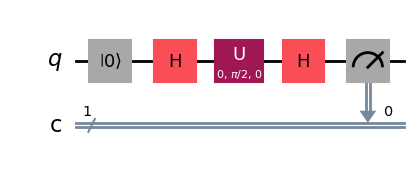

In [6]:
# ramsey sequence 2: hadamard gate to rotate the qubit back to the 0 or 1 state
circuit.h(0)

# measure the qubit and provide a histogram of the results
circuit.measure(0,0)

# print the circuit
circuit.draw('mpl')

We can determine the probability of the qubit being in the state $\ket{1}$ to demonstrate that the phase information has been successfully encoded.

$$
P[\ket{0}] = |\frac{1+e^{i\theta}}{2}|^2
$$

$$
P[\ket{1}] = |\frac{1-e^{i\theta}}{2}|^2
$$

We can use Euler's Formula to simplify these equations.
$$e^{i\theta} = \cos(\theta)+i\sin(\theta)$$
$$e^{i\theta} + e^{-i\theta} = \cos(\theta) + i\sin(\theta) +  \cos(\theta) - i\sin(\theta) = 2\cos(\theta)$$
$$\cos(\theta) = \frac{1}{2}(e^{i\theta} + e^{-i\theta})$$
$$|\cos(\theta)|^2 = |\frac{e^{i\theta} + e^{-i\theta}}{2}|^2= |\frac{e^{-i \theta} ( 1+e^{2i \theta} ) }{2}|^2 =|\frac{ 1+e^{2i \theta}}{2}|^2  $$

Replace $\theta$ with $\frac{\theta}{2}$:
        $$|\cos(\frac{\theta}{2})|^2 =|\frac{ 1+e^{i \theta}}{2}|^2 = P[\ket{0}] $$

Since $P[\ket{0}]$ + $P[\ket{1}]$ = 1, $P[\ket{1}] = |\sin(\frac{\theta}{2})|^2$.

 Extracting the Phase Shift: $P[\ket1] =  |\sin(\frac{\theta}{2})|^2$ and $P[\ket0]= |\cos(\frac{\theta}{2})|^2$

 
### Solving for $P[\ket0]$
$$P[\ket0]= |\cos(\frac{\theta}{2})|^2 = |\cos^2(\frac{\theta}{2})| =\frac{1+\cos(\theta)}{2}$$
for $\theta \in [0, 2\pi]$

### Solving for $P[\ket1]$
$$P[\ket1] = |\sin(\frac{\theta}{2})|^2 = |\sin^2(\frac{\theta}{2})|  = \frac{1-\cos(\theta)}{2}$$
for $\theta \in [0, 2\pi]$

In [7]:
# transpile the circuit to the Aer simulator
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(circuit, simulator)

# Number of times the experiment is run
shots = 1000

# plot a histogram shots is the number of times the circuit is run(will be elaborated on later)
job = simulator.run(compiled_circuit, shots=shots)
result = job.result()

counts = result.get_counts()

# probbility of the qubit being in the 0 state
probability0 = 0 if '0' not in counts else counts['0']/shots
probability1 = 0 if '1' not in counts else counts['1']/shots

print("Probability of the qubit being in the 0 state: ", probability0)
print("Probability of the qubit being in the 1 state: ", probability1)


Probability of the qubit being in the 0 state:  0.491
Probability of the qubit being in the 1 state:  0.509


### 2.1 Relating the Probability of $\ket{1}$ to $\theta$

We can use this function to relate the probability of $\ket{1}$ to $\theta$ and obtain a reading of $\theta$. We then calculate and print the error between our calculated $\theta$ and the expected value of $\theta = \frac{\pi}{2}$.

$$P[\ket1] = \frac{1-\cos(\theta)}{2}$$
$$2P[\ket1] - 1 = -\cos(\theta) $$
$$\theta = \arccos(-(2P[\ket1] - 1))$$

In [8]:
# calculate the phase from the probability of ones
phase = math.acos((probability1*2-1)*-1)

print("Calculated Phase:", phase)
print("Actual Phase:", phaseAmount)

# calculate the phase error
phaseError = abs(phase - phaseAmount)
print("Phase Error:", phaseError)

Calculated Phase: 1.5887972989366417
Actual Phase: 1.5707963267948966
Phase Error: 0.01800097214174512
